In [1]:
#Acceder a carpetas de Google Drive
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
%cd /content/gdrive/My Drive/Research/UOH/

Mounted at /content/gdrive/
/content/gdrive/My Drive/Research/UOH


In [2]:
#Instalación de bibliotecas en Google Colab

#Machine learning (básica)
!pip install scikit-learn --q

#Machine learning (deep learning)
!pip install tensorflow --q
!pip install keras --q
!pip install torch --q

#Comentarios:
#'!': solo se usa en colab
#'==': permite especificar una versión de la biblioteca a instalar
#'--quiet' o '-q': instalación silenciosa de bibliotecas

In [3]:
#Uso de bibliotecas
import numpy as np
from matplotlib import pylab
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
# https://scikit-learn.org/stable/
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, PredefinedSplit
from sklearn.svm import SVC
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# https://keras.io/
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from collections import Counter
import numpy as np
import os
import random
from scipy.stats import entropy
import copy

SEED = 42

#reproducible results
def reproducible_results(seed):  
  np.random.seed(seed)
  random.seed(seed)
  os.environ['PYTHONHASHSEED']=str(0)
  tf.compat.v1.set_random_seed(seed)

reproducible_results(SEED)

In [4]:
url = 'https://datahub.io/machine-learning/diabetes/r/diabetes.csv'
df = pd.read_csv(url)
df.head(10)

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,tested_positive
1,1,85,66,29,0,26.6,0.351,31,tested_negative
2,8,183,64,0,0,23.3,0.672,32,tested_positive
3,1,89,66,23,94,28.1,0.167,21,tested_negative
4,0,137,40,35,168,43.1,2.288,33,tested_positive
5,5,116,74,0,0,25.6,0.201,30,tested_negative
6,3,78,50,32,88,31.0,0.248,26,tested_positive
7,10,115,0,0,0,35.3,0.134,29,tested_negative
8,2,197,70,45,543,30.5,0.158,53,tested_positive
9,8,125,96,0,0,0.0,0.232,54,tested_positive


In [5]:
df.describe()

,preg,plas,pres,skin,insu,mass,pedi,age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [6]:
df.values.shape

(768, 9)

In [7]:
le = LabelEncoder()
df['class'] = le.fit_transform(df['class'])
df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
counter = Counter( df['class'] )
counter

Counter({1: 268, 0: 500})

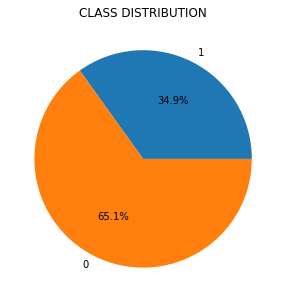

In [9]:
fig = pylab.figure(1, figsize=(5,5))
pylab.pie(counter.values(), labels=counter.keys(), autopct='%1.1f%%')
pylab.title('CLASS DISTRIBUTION')
pylab.show()

In [10]:
classes = df['class'].values.copy()
df.drop(columns=['class'], inplace=True)
data = df.values.copy()
df.head()

,preg,plas,pres,skin,insu,mass,pedi,age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [11]:
#Entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(data, classes, test_size=0.2, random_state=SEED)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#SVM
clf_A = SVC(kernel='rbf', C=1000, random_state=SEED)
clf_A.fit(X_train, y_train)
print('ACC (%) A: ', 100*accuracy_score(y_test, clf_A.predict(X_test)))

#Árbol de decisión
clf_B = ExtraTreeClassifier(random_state=SEED)
clf_B.fit(X_train, y_train)
print('ACC (%) B: ', 100*accuracy_score(y_test, clf_B.predict(X_test)))

#Random Forest
clf_C = RandomForestClassifier(random_state=SEED)
clf_C.fit(X_train, y_train)
print('ACC (%) C: ', 100*accuracy_score(y_test, clf_C.predict(X_test)))

#Red neuronal
def ANN(n_cols, seed=SEED):
  reproducible_results(seed)
  initializer = tf.keras.initializers.GlorotUniform(seed = seed)
  model = Sequential()
  model.add(Dense(128, input_shape=(n_cols,), activation='relu', kernel_initializer=initializer))
  model.add(Dense(32, activation='relu', kernel_initializer=initializer))
  model.add(Dense(1, activation='sigmoid', kernel_initializer=initializer))
  model.compile(optimizer='adam', loss='binary_crossentropy')
  return model

clf_D = ANN(X_train.shape[1])
early_stopping_monitor = EarlyStopping(patience=5, monitor='val_loss', mode='min', verbose=0)
history = clf_D.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks=[early_stopping_monitor], verbose=0)
print('ACC (%) D: ', 100*accuracy_score(y_test,  (clf_D.predict(X_test)>0.5).astype(int)))

ACC (%) A:  64.93506493506493
ACC (%) B:  66.23376623376623
ACC (%) C:  72.07792207792207
5/5 [==============================] - 0s 2ms/step
ACC (%) D:  75.32467532467533


In [12]:
#Fuente (imagen): https://www.researchgate.net/publication/278826818_Feature_extraction_and_supervised_learning_on_fMRI_from_practice_to_theory
#Python: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

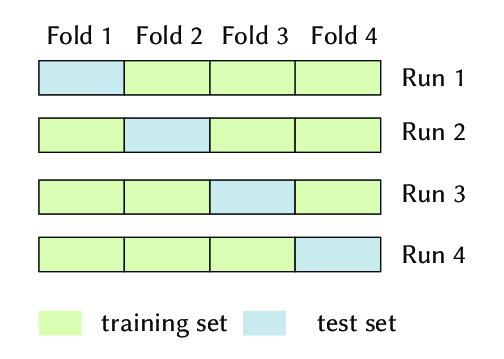

In [13]:
#Ajuste de parámetros (ejemplo para SVM)
param_grid = {'kernel':('linear', 'rbf'), 'C':[1, 10, 100]}
gs_A = GridSearchCV(clf_A, param_grid=param_grid, cv=5, scoring='accuracy')
gs_A.fit( X_train, y_train )
params_A = gs_A.best_params_.copy()
params_A.update({'random_state':SEED})
print('Params:', params_A)
clf_A = SVC( **params_A )
clf_A.fit(X_train, y_train)
#nuevo desempeño
print('ACC (%) A: ', 100*accuracy_score(y_test, clf_A.predict(X_test)))

Params: {'C': 1, 'kernel': 'rbf', 'random_state': 42}
ACC (%) A:  73.37662337662337


In [14]:
#Reducción de dimensionalidad (PCA)
#Previamente los datos ya han sido estandarizados (media, desviación estándar)
pca = PCA(n_components=7, random_state=SEED)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
clf_A.fit(X_train_pca, y_train)
print('PCA:', X_train_pca.shape)
#nuevo desempeño
print('ACC (%) A: ', 100*accuracy_score(y_test, clf_A.predict(X_test_pca)))

PCA: (614, 7)
ACC (%) A:  75.97402597402598


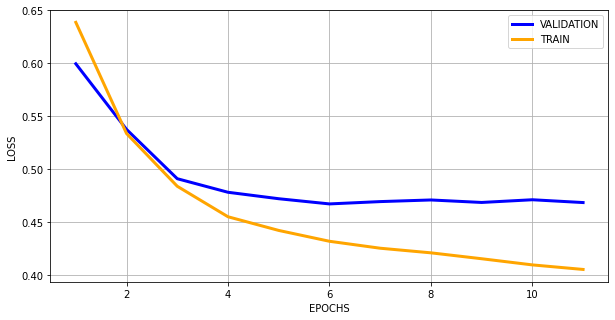

In [15]:
#error de entrenamiento/validación en la red neuronal
val_loss = history.history['val_loss']
train_loss = history.history['loss']
epochs = np.arange(1, len(val_loss)+1)
fig = pylab.figure(1, figsize=(10,5))
pylab.plot(epochs, val_loss, label='VALIDATION', c='blue', lw=3)
pylab.plot(epochs, train_loss, label='TRAIN', c='orange', lw=3)
pylab.grid(True)
pylab.xlabel('EPOCHS')
pylab.ylabel('LOSS')
pylab.legend(loc='upper right')
pylab.show()

In [16]:
#Material adicional (árbol de decisión)
#Fuente: https://www.nebrija.es/~cmalagon/inco/apuntes_mios/ejemplo_ID3_clase.pdf

In [17]:
P = [5/14, 9/14]
E = 0
for pi in P:
  E += -pi*np.log2(pi)
E

0.9402859586706309

In [18]:
P = [5/14, 9/14]
entropy(P, base=2)

0.940285958670631

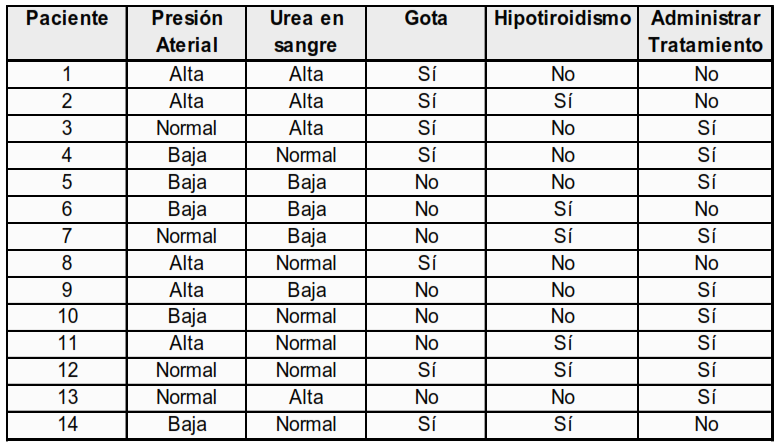

In [19]:
#Material adicional (Naïve Bayes)
#Fuente: https://webdocs.cs.ualberta.ca/~zaiane/courses/cmput695/F07/exercises/Exercises695Clas-solution.pdf

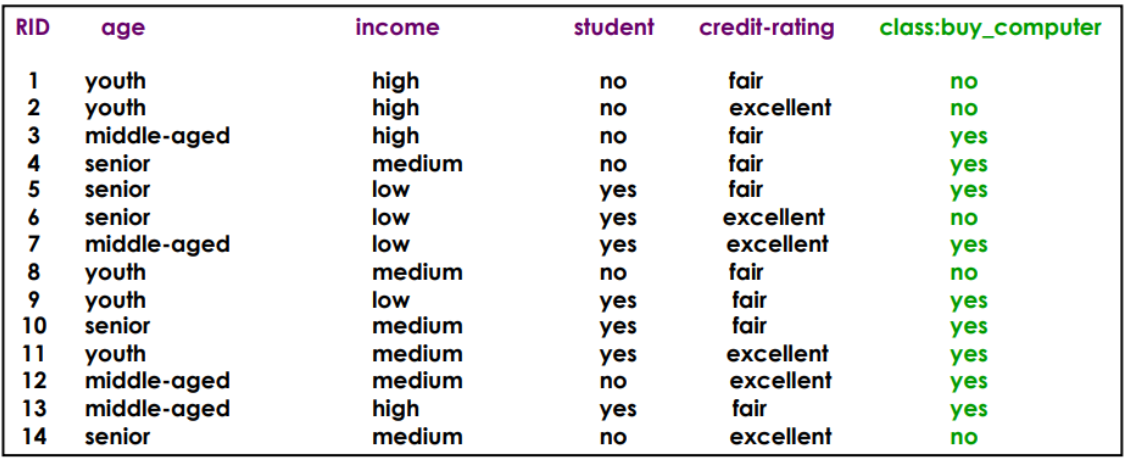